In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchtext
import tqdm
import sys

In [2]:
train_iter = torchtext.datasets.IMDB(split='train')

In [3]:
tokenizor = torchtext.data.utils.get_tokenizer('basic_english')

In [4]:
tokens = []
for label, line in train_iter:
    tokens += tokenizor(line)

In [5]:
from collections import Counter, OrderedDict
# from torchtext.vocab import Vocab

counter = Counter(tokens) # unsorted dict
sorted_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_tuples)
Vocab = torchtext.vocab.vocab(ordered_dict, min_freq=10)

# adding <unk> token and default index
unk_token = '<unk>'
default_index = 0
if unk_token not in Vocab:
    Vocab.insert_token(unk_token, default_index)
Vocab.set_default_index(default_index)

# adding <pad> token
Vocab.insert_token('<pad>', 1)

In [6]:
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import random

text_transform = lambda x: [Vocab[token] for token in tokenizor(x)]
label_transform = lambda x: 1 if x == 'pos' else 0

def collate_batch(batch):
    label_list, text_list, text_lengths = [], [], []
    for label, text in batch:
        text_list.append(torch.tensor(text_transform(text)))
        text_lengths.append(len(text_list[-1]))
        label_list.append(label_transform(label))

    return torch.tensor(label_list), pad_sequence(text_list, padding_value=Vocab['<pad>']), text_lengths

train_iter, test_iter = torchtext.datasets.IMDB(split=('train', 'test'))

class dataset_from_iter(Dataset):
    def __init__(self, train_iter):
        self.labels, self.text = [], []
        for label, line in train_iter:
            self.labels.append(label)
            self.text.append(line)
    
    def __getitem__(self, index):
        return self.labels[index], self.text[index]
    
    def __len__(self):
        return len(self.labels)

train_dataset = dataset_from_iter(train_iter)

In [7]:
batch_size = 95

n_train = len(train_dataset)
split = n_train // 3
indices = list(range(n_train))
random.shuffle(indices)
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[split:])
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[:split])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=collate_batch)
valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, collate_fn=collate_batch)
test_dataloader = DataLoader(test_iter, batch_size=batch_size, collate_fn=collate_batch)

In [8]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim*2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths=text_lengths, enforce_sorted=False)

        _, (hidden, _) = self.rnn(packed_embedded)

        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # [batch_size, hidden_dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # [batch_size, hidden_dim]
        
        predictions = self.fc(hidden)

        return predictions

In [9]:
vocab_size = len(Vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = 2
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, pad_index=Vocab.get_stoi()['<pad>'])

In [10]:
# pretrained embedding model
# vectors = torchtext.vocab.FastText()
# pretrained_embeddeing = vectors(Vocab.get_itos())
# model.embedding.weight.data = pretrained_embeddeing

In [11]:
lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

model = model.to(device)
criterion = criterion.to(device)

In [12]:
def get_accuracy(preds, labels):
    batch_size = preds.size(0)
    predicted_classes = preds.argmax(1)
    n_correct = predicted_classes.eq(labels).sum()
    acc = n_correct / batch_size

    return acc

In [13]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for labels, text, text_lengths in tqdm.tqdm(data_loader, desc='Training  ', file=sys.stdout):
        labels = labels.to(device)
        text = text.to(device)

        predictions = model(text, text_lengths)
        loss = criterion(predictions, labels)
        acc = get_accuracy(predictions, labels)

        epoch_losses.append(loss.item())
        epoch_accs.append(acc.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return epoch_losses, epoch_accs

In [14]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    losses = []
    accs = []

    with torch.no_grad():
        for labels, text, text_lengths in tqdm.tqdm(data_loader, desc='Evaluating', file=sys.stdout):
            labels = labels.to(device)
            text = text.to(device)

            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            acc = get_accuracy(predictions, labels)

            losses.append(loss.item())
            accs.append(acc.item())
        
    return losses, accs

In [15]:
n_epoch = 10
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epoch):
    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    train_loss_mean = np.mean(train_loss)
    train_acc_mean = np.mean(train_acc)
    valid_loss_mean = np.mean(valid_loss)
    valid_acc_mean = np.mean(valid_acc)

    if valid_loss_mean < best_valid_loss:
        best_valid_loss = valid_loss_mean
        torch.save(model.state_dict(), 'best_model2')
    
    print(f'epoch: {epoch+1:02}')
    print(f'train loss: {train_loss_mean:.3f}, train acc: {train_acc_mean*100:.2f}%')
    print(f'valid loss: {valid_loss_mean:.3f}, valid acc: {valid_acc_mean*100:.2f}%')

Evaluating: 100%|██████████| 88/88 [00:21<00:00,  4.11it/s]
epoch: 01
train loss: 0.644, train acc: 62.45%
valid loss: 0.577, valid acc: 70.49%
Evaluating: 100%|██████████| 88/88 [00:21<00:00,  4.12it/s]
epoch: 02
train loss: 0.552, train acc: 71.63%
valid loss: 0.729, valid acc: 68.27%
Evaluating: 100%|██████████| 88/88 [00:21<00:00,  4.11it/s]
epoch: 03
train loss: 0.492, train acc: 76.32%
valid loss: 0.449, valid acc: 79.63%
Evaluating: 100%|██████████| 88/88 [00:21<00:00,  4.11it/s]
epoch: 04
train loss: 0.444, train acc: 79.27%
valid loss: 0.410, valid acc: 81.03%
Evaluating: 100%|██████████| 88/88 [00:21<00:00,  4.01it/s]
epoch: 05
train loss: 0.417, train acc: 80.76%
valid loss: 0.735, valid acc: 68.68%
Evaluating: 100%|██████████| 88/88 [00:21<00:00,  4.09it/s]
epoch: 06
train loss: 0.431, train acc: 80.08%
valid loss: 0.959, valid acc: 63.44%
Evaluating: 100%|██████████| 88/88 [00:21<00:00,  4.09it/s]
epoch: 07
train loss: 0.361, train acc: 84.24%
valid loss: 0.575, valid acc:

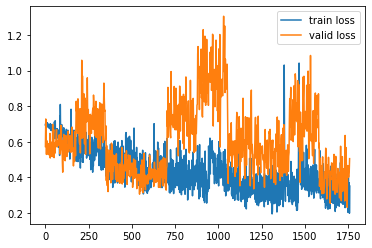

In [23]:
'''
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
'''
x_train = list(range(1760))
x_eval = list(range(0, 1760, 2))

plt.plot(x_train, train_losses, label='train loss')
plt.plot(x_eval, valid_losses, label='valid loss')

plt.legend()
plt.show()

In [17]:
model.load_state_dict(torch.load('best_model'))
test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

test_loss_mean = np.mean(test_loss)
test_acc_mean = np.mean(test_acc)

print(f'test loss: {test_loss_mean:.3f}, test acc: {test_acc_mean*100:.2f}%')

Evaluating: 100%|██████████| 264/264 [02:17<00:00,  1.93it/s]
test loss: 0.312, test acc: 88.40%
